### Basic Tutorial: Jax Version


The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

In [12]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch
import pickle
from lanfactory.utils import clean_out_folder

In [20]:
import pathlib
import logging
logger = logging.getLogger(__name__)

def print_tree(
    path: pathlib.Path | str,
    prefix: str = "",
    logger: logging.Logger | None = None,
    out_str_list: list[str] = [],
) -> list[str]:
    """Print a directory tree structure starting from the given path.

    This function recursively traverses the directory structure and prints
    a visual representation of the file hierarchy.

    Arguments
    ---------
        path (Path):
            The directory path to start printing from
        prefix (str, optional):
            Prefix string used for indentation in recursive calls.
            Defaults to an empty string.

    Returns
    -------
        None

    Example
    -------
        from pathlib import Path
        print_tree(Path("./my_directory"))
    """
    path = pathlib.Path(path)
    contents = sorted(path.iterdir(), key=lambda p: (not p.is_dir(), p.name.lower()))
    for index, item in enumerate(contents):
        connector = "└── " if index == len(contents) - 1 else "├── "
        out_str = prefix + connector + item.name
        if logger is not None:
            logger.info(out_str)
        else:
            print(out_str)
            out_str_list.append(out_str)
        if item.is_dir():
            extension = "    " if index == len(contents) - 1 else "│   "
            out_str_list = print_tree(item, prefix + extension, logger, out_str_list)
    return out_str_list


def print_str_list(str_list: list[str], logger: logging.Logger | None = logger):
    """Print each string in a list of strings.

    This function iterates through a list of strings and prints each one,
    either using a logger if provided or standard print output.

    Arguments
    ---------
        str_list (list[str]):
            The list of strings to print
        logger (logging.Logger, optional):
            Logger to use for printing. If None, standard print is used.
            Defaults to the module's logger.

    Returns
    -------
        None

    Example
    -------
        print_str_list(["Line 1", "Line 2"])
    """
    for str_ in str_list:
        if logger is not None:
            logger.info(str_)
        else:
            print(str_)


In [22]:
out = print_tree(path = 'data')

├── jax_models
│   ├── ddm
│   │   ├── ddm_jax_cpn_data_details.pickle
│   │   ├── ddm_jax_cpn_network_config.pickle
│   │   ├── ddm_jax_cpn_train_config.pickle
│   │   ├── ddm_jax_cpn_train_state.jax
│   │   ├── ddm_jax_cpn_training_history.csv
│   │   ├── ddm_jax_lan_data_details.pickle
│   │   ├── ddm_jax_lan_network_config.pickle
│   │   ├── ddm_jax_lan_train_config.pickle
│   │   ├── ddm_jax_lan_train_state.jax
│   │   ├── ddm_jax_lan_training_history.csv
│   │   ├── jax_network_config.pickle
│   │   ├── test_run_notebook_lan_ddm__data_details.pickle
│   │   ├── test_run_notebook_lan_ddm__jax_training_history.csv
│   │   ├── test_run_notebook_lan_ddm__train_config.pickle
│   │   └── test_run_notebook_lan_ddm__train_state.jax
│   └── .DS_Store
├── lan_mlp
│   ├── angle
│   │   ├── training_data_00e6ae46c56e11eeaa8e6ae25f443f62.pickle
│   │   ├── training_data_0c5ebee0c56d11eeaa8e6ae25f443f62.pickle
│   │   ├── training_data_0d65b44ac56a11eeaa8e6ae25f443f62.pickle
│   │   ├── traini

In [24]:
print_str_list(out, logger=None)

├── jax_models
│   ├── ddm
│   │   ├── ddm_jax_cpn_data_details.pickle
│   │   ├── ddm_jax_cpn_network_config.pickle
│   │   ├── ddm_jax_cpn_train_config.pickle
│   │   ├── ddm_jax_cpn_train_state.jax
│   │   ├── ddm_jax_cpn_training_history.csv
│   │   ├── ddm_jax_lan_data_details.pickle
│   │   ├── ddm_jax_lan_network_config.pickle
│   │   ├── ddm_jax_lan_train_config.pickle
│   │   ├── ddm_jax_lan_train_state.jax
│   │   ├── ddm_jax_lan_training_history.csv
│   │   ├── jax_network_config.pickle
│   │   ├── test_run_notebook_lan_ddm__data_details.pickle
│   │   ├── test_run_notebook_lan_ddm__jax_training_history.csv
│   │   ├── test_run_notebook_lan_ddm__train_config.pickle
│   │   └── test_run_notebook_lan_ddm__train_state.jax
│   └── .DS_Store
├── lan_mlp
│   ├── angle
│   │   ├── training_data_00e6ae46c56e11eeaa8e6ae25f443f62.pickle
│   │   ├── training_data_0c5ebee0c56d11eeaa8e6ae25f443f62.pickle
│   │   ├── training_data_0d65b44ac56a11eeaa8e6ae25f443f62.pickle
│   │   ├── traini

In [2]:
# MAKE CONFIGS
RUN_SIMS = True
DEVICE = "cpu"

# Define a model
MODEL = "race_4" #list(ssms.config.model_config.keys())[np.random.randint(0, len(ssms.config.model_config.keys()))]
OUT_FOLDER = os.path.join("test_data", "lan_mlp", "training_data")
MODEL_FOLDER = os.path.join("test_data", "jax_models", "lan")
N_DATA_FILES = 2
os.makedirs(OUT_FOLDER, exist_ok=True)

# Initialize the generator config (for MLP LANs)

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 256
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = OUT_FOLDER
generator_config['n_training_samples_by_parameter_set'] = 2000

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [29]:
clean_out_folder(dry_run=False)

[('test_data/jax_models', 'directory'), ('test_data/lan_mlp', 'directory')]

In [4]:
# import shutil
# import os
# import glob
# from typing import List, Tuple

# # ADD THIS TO BASIC UTILITIES?
# def clean_out_folder(folder_="test_data", dry_run=True) -> List[Tuple[str, str]]:
#     """Safely remove all contents of a folder with optional dry-run mode.
    
#     Args:
#         folder_ (str): Path to the folder to clean out
#         dry_run (bool): If True, only prints what would be removed without actually deleting
        
#     Returns:
#         List[Tuple[str, str]]: List of tuples containing (item_path, action_type)
#         where action_type is either 'file' or 'directory'
        
#     Example:
#         # Preview what would be deleted
#         items = clean_out_folder("test_data", dry_run=True)
#         for path, item_type in items:
#             print(f"Would remove {item_type}: {path}")
            
#         # Actually delete the items
#         clean_out_folder("test_data", dry_run=False)
#     """
#     if not os.path.exists(folder_):
#         print(f"Folder '{folder_}' does not exist.")
#         return []
    
#     items_to_remove = []
    
#     # Collect all items that would be removed
#     for item in glob.glob(os.path.join(folder_, "*")):
#         if os.path.isfile(item):
#             items_to_remove.append((item, 'file'))
#         elif os.path.isdir(item):
#             items_to_remove.append((item, 'directory'))
    
#     # Actually remove the items
#     for item_path, item_type in items_to_remove:
#         try:
#             if item_type == 'file':
#                 if dry_run:
#                     print(f"Would remove file: {os.path.basename(item_path)}")
#                 else:
#                     os.remove(item_path)
#             else:
#                 if dry_run:
#                     print(f"Would remove directory: {os.path.basename(item_path)}")
#                 else:
#                     shutil.rmtree(item_path)
#         except PermissionError:
#             print(f"Permission denied when trying to remove {item_type}: {item_path}")
#         except Exception as e:
#             print(f"Error removing {item_type} {item_path}: {str(e)}")

#     return items_to_remove

In [23]:
# tests/constants.py
@dataclass
class TestConstants:
    """Test configuration constants."""
    MODEL: str = "angle"
    N_PARAMETER_SETS: int = 256
    N_SAMPLES: int = 2000
    N_TRAINING_SAMPLES: int = 2000
    N_SAMPLE_BY_PARAMETER_SET: int = 2000
    TEST_FOLDER: str = "test_data"
    OUT_FOLDER: str = "test_data/lan_mlp/training_data"
    MODEL_FOLDER: str = "test_data/jax_models/lan"
    N_DATA_FILES: int = 2
    DEVICE: str = "cpu"

# Create an instance
TEST_CONSTANTS = TestConstants()

In [24]:
TEST_CONSTANTS

TestConstants(N_PARAMETER_SETS=256, N_SAMPLES=2000, N_TRAINING_SAMPLES=2000, TEST_FOLDER='test_data', OUT_FOLDER='test_data/lan_mlp/training_data', MODEL_FOLDER='test_data/jax_models/lan', N_DATA_FILES=2, DEVICE='cpu')

In [22]:
TEST_CONSTANTS.OUT_FOLDER

'test_data/lan_mlp/training_data'

In [30]:
# MAKE DATA
if RUN_SIMS:
    for i in range(N_DATA_FILES):
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        _ = my_dataset_generator.generate_data_training_uniform(save=True)

n_cpus used:  12
checking:  test_data/lan_mlp/training_data
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  test_data/lan_mlp/training_data/training_data_d8f82f4419b411f08cbc6ae25f443f61.pickle
n_cpus used:  12
checking:  test_data/lan_mlp/training_data
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  test_data/lan_mlp/training_data/training_data_db3f3ce819b411f08cbc6ae25f443f61.pickle


In [3]:
from copy import deepcopy

# MAKE FIXTURE WITH SOMEWHAT RANDOM PROPERTIES
network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config["layer_sizes"] = [100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "linear"]

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)
train_config["learning_rate"] = 0.000002

print("Train config: ")
print(train_config)

# CHECK CORNER CASES
train_config["cpu_batch_size"] = 4196
train_config["gpu_batch_size"] = 4196
train_config["n_epochs"] = 2

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 2e-06, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [32]:
network_config

{'layer_sizes': [100, 100, 100, 1],
 'activations': ['tanh', 'tanh', 'tanh', 'linear'],
 'train_output_type': 'logprob'}

In [33]:
network_config

{'layer_sizes': [100, 100, 100, 1],
 'activations': ['tanh', 'tanh', 'tanh', 'linear'],
 'train_output_type': 'logprob'}

In [34]:
train_config

{'cpu_batch_size': 4196,
 'gpu_batch_size': 4196,
 'n_epochs': 2,
 'optimizer': 'adam',
 'learning_rate': 2e-06,
 'lr_scheduler': 'reduce_on_plateau',
 'lr_scheduler_params': {},
 'weight_decay': 0.0,
 'loss': 'huber',
 'save_history': True}

#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [4]:
# folder_ = OUT_FOLDER
file_list_ = [os.path.join(OUT_FOLDER, file_) for file_ in os.listdir(OUT_FOLDER)]


# INDEPENDENT TESTS OF DATALOADERS
# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

#### Define Network

In [5]:
# LOAD NETWORK
# Test properties of network
jax_net = lanfactory.trainers.MLPJaxFactory(network_config=network_config, train=True)

# Save model config
# model_folder = os.path.join("data", "jax_models", MODEL)
# os.makedirs(model_folder, exist_ok = True)

# pickle.dump(
#     network_config,
#     open(os.path.join(model_folder,
# 					  "jax_network_config.pickle"), "wb")
# 		)

#### Train 

In [6]:
# Test properties of jax trainer
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [38]:
jax_trainer.train_dl.dataset.file_ids

['test_data/lan_mlp/training_data/training_data_d8f82f4419b411f08cbc6ae25f443f61.pickle',
 'test_data/lan_mlp/training_data/training_data_db3f3ce819b411f08cbc6ae25f443f61.pickle']

In [7]:
# Test if training loop works
train_state = jax_trainer.train_and_evaluate(
    output_folder=MODEL_FOLDER,
    output_file_id=MODEL,
    run_id="jax",
    wandb_on=False,
    wandb_project_id="jax",
    save_data_details=True,
    verbose=1,
    save_all=True,
)

Found folder:  test_data
Moving on...
Found folder:  test_data/jax_models
Moving on...
Found folder:  test_data/jax_models/lan
Moving on...
Epoch: 0 of 2
wandb not available
wandb not available
Training - Step: 0 of 238 - Loss: 5.0046573
Epoch 0/2 time: 8.082781791687012s
wandb not available
wandb not available
Validation - Step: 0 of 238 - Loss: 0.282281
Epoch 0/2 time: 7.53375506401062s
Epoch: 0 / 2, test_loss: 0.31512847542762756
Epoch: 1 of 2
wandb not available
wandb not available
Training - Step: 0 of 238 - Loss: 0.3006714
Epoch 1/2 time: 8.112329959869385s
wandb not available
wandb not available
Validation - Step: 0 of 238 - Loss: 0.1684954
Epoch 1/2 time: 7.711026906967163s
Epoch: 1 / 2, test_loss: 0.1780492067337036
Saving training history to: test_data/jax_models/lan/jax_lan_race_4__jax_training_history.csv
Saving model parameters to: test_data/jax_models/lan/jax_lan_race_4__train_state.jax
Saving training config to: test_data/jax_models/lan/jax_lan_race_4__train_config.pickl

#### Check Trained Network

We can now re-instantiate our network from the trained weights and check that the output are reasonable.

In [8]:
# Loaded Net
# Test passing network config as path and as object

jax_infer = lanfactory.trainers.MLPJaxFactory(
	            network_config=network_config,
                train=False,
            )

In [44]:
model_config["n_params"]

10

In [45]:
os.path.join(MODEL_FOLDER,
					   "jax_lan_" + MODEL + "__train_state.jax")

'test_data/jax_models/lan/jax_lan_race_4__train_state.jax'

In [9]:
import jax
jax.load(os.path.join(MODEL_FOLDER,
					   "jax_lan_" + MODEL + "__train_state.jax"))

AttributeError: module 'jax' has no attribute 'load'

In [10]:
# Test passing train state as path and as object
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state=os.path.join(MODEL_FOLDER,
					   "jax_lan_" + MODEL + "__train_state.jax"),
    add_jitted=True,
)

In [55]:
jax_infer.load_state_from_file(file_path=os.path.join(MODEL_FOLDER,
					   "jax_lan_" + MODEL + "__train_state.jax"))['params']['layers_0']['kernel'].shape

(12, 100)

In [61]:
net_out = forward_pass_jitted(jnp.zeros((10000, 12)))

In [64]:
forward_pass_jitted(input_mat)

Array([[-15.466729],
       [-15.451612],
       [-15.436448],
       ...,
       [-20.471233],
       [-20.478128],
       [-20.484968]], dtype=float32)

In [41]:
# Test forward pass dimensionality
forward_pass()
forward_pass_jitted()


TypeError: MLPJax.__call__() missing 1 required positional argument: 'inputs'

In [11]:
import jax.numpy as jnp

# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]["default_params"])

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(
    model=MODEL, theta=theta, n_samples=50000
)

# Make input metric
input_mat = jnp.zeros((2000, len(theta) + 2))
for i in range(len(theta)):
    input_mat = input_mat.at[:, i].set(jnp.ones(2000) * theta[i])

input_mat = input_mat.at[:, len(theta)].set(
    jnp.array(
        np.concatenate(
            [
                np.linspace(5, 0, 1000).astype(np.float32),
                np.linspace(0, 5, 1000).astype(np.float32),
            ]
        )
    )
)
input_mat = input_mat.at[:, len(theta) + 1].set(
    jnp.array(
        np.concatenate([np.repeat(-1.0, 1000), np.repeat(1.0, 1000)]).astype(np.float32)
    )
)

net_out = forward_pass_jitted(input_mat)

(array([1.08902138e-04, 1.08902138e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.08902138e-04, 0.00000000e+00,
        1.08902138e-04, 0.00000000e+00, 0.00000000e+00, 4.35608553e-04,
        1.08902138e-04, 5.44510691e-04, 0.00000000e+00, 1.08902138e-04,
        4.35608553e-04, 3.26706415e-04, 5.44510691e-04, 8.71217106e-04,
        7.62314968e-04, 8.71217106e-04, 1.19792352e-03, 1.63353207e-03,
        2.17804277e-03, 3.26706415e-03, 3.37596629e-03, 5.66291119e-03,
        5.00949836e-03, 6.75193257e-03, 7.18754113e-03, 1.04546053e-02,
        1.51373972e-02, 1.64442229e-02, 2.16715255e-02, 2.49385897e-02,
        3.09282073e-02, 3.88780634e-02, 5.09662007e-02, 6.46878701e-02,
        7.90629524e-02, 1.02150206e-01, 1.26544285e-01, 1.51373972e-01,
        1.92647883e-01, 2.23467188e-01, 2.96758327e-01, 3.64386555e-01,
        4.36806477e-01, 3.81266386e-01, 4.46498767e-02, 1.55947862e-01,
        4.31252468e-01, 4.00433163e-01, 3.35200782e-01, 2.693149

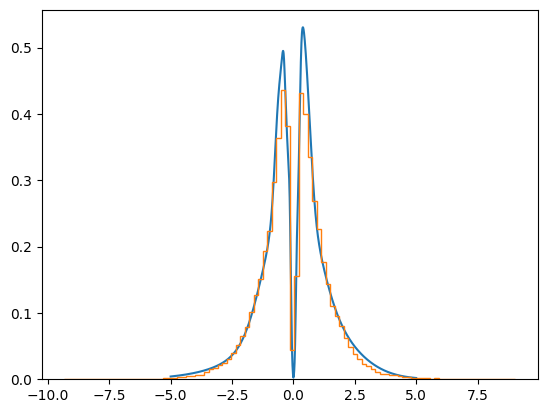

In [17]:
from matplotlib import pyplot as plt

# Plot network log likelihood
plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), np.exp(net_out))

# Plot simulation histogram
plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    fill=None,
    density=True,
)